* как соотносятся темы с пунктом специальности

паспорт специальности ВАК стоматология

* посчитать количество документов для каждой темы

In [81]:
%config Completer.use_jedi = False

In [82]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
import pandas as pd
from tqdm.notebook import tqdm
import re
from typing import List
import os
import matplotlib.pyplot as plt
import numpy as np

In [84]:
import os
import functools

In [160]:
%%time
df = pd.read_excel('../data/avtoreferati.xlsx', sheet_name='Итог', header=0)

CPU times: user 3.64 s, sys: 0 ns, total: 3.64 s
Wall time: 3.5 s


In [163]:
df['Пункты паспорта специальности (области исследования) 1-ой специальности']

0         2.5
1           3
2       3,4,5
3           3
4         3.4
        ...  
5793      NaN
5794      NaN
5795      NaN
5796      NaN
5797      NaN
Name: Пункты паспорта специальности (области исследования) 1-ой специальности, Length: 5798, dtype: object

In [86]:
tasks_aux = {k: f't{k}' for k in range(1, 14)}
# 1: 't1', 2: 't2', 3: 't3', 4: 't4', 5: 't5', 6: 't6', 7: 't7', 8: 't8', 9: 't9', 10: 't10', 11: 't11', 12: 't12', 13: 't13'
res_aux = {f'{k}.1' : f'r{k}' for k in range(1, 14)}
res_aux

res_aux.update({k: f'r{k}' for k in range(14, 21)})

In [87]:
df.rename(
    columns={'Годзащиты': 'year', 'Unnamed: 29': 'title', 
            **tasks_aux,
            **res_aux,}, 
    inplace=True
)

In [88]:
df = df[['year', *list(res_aux.values())]]

In [89]:
df = df.dropna()

In [90]:
df['year'] = df.year.astype(int)

In [91]:
df.shape

(1263, 21)

### рассматриваем только результаты (без задач)

In [92]:
df['text'] = df.apply(lambda row: 
                        row['r1'] + '. ' + row['r2'] + '. ' + row['r3'] + '. ' + \
                        row['r4'] + '. ' + row['r5'] + '. ' + row['r6'] + '. ' + \
                        row['r7'] + '. ' + row['r8'] + '. ' + row['r9'] + '. ' + \
                        row['r10'] + '. ' + row['r11'] + '. ' + row['r12'] + '. ' + \
                        row['r13'] + '. ' + row['r14'] + '. ' + row['r15'] + '. ' + \
                        row['r16'] + '. ' + row['r17'] + '. ' + row['r18'] + '. ' + \
                        row['r19'] + '. ' + row['r20'],
                        axis=1)

### Preprocessing

In [93]:
import pymorphy2
import os
from typing import List
import razdel

import nltk
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('russian')

cyrillic = re.compile(r'[^а-я ]')
mult_ws = re.compile(r'\s+')
fix_punct = re.compile(r'\s+(\?|\.|,|!|:)')

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /home/uadmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
def process_regex(re_words_to_remove,
                  re_mult_ws,
                  text: str) -> str:
    '''
    строковый предпроцессинг предложения
    '''
    text = text.lower()
    text = re.sub(re_words_to_remove, ' ', text)
    text = re.sub(re_mult_ws, ' ', text)
    text = text.strip()
    return text

In [95]:
def lemmatize(text: str, lemmatizer, min_word_size: int = 5) -> List[str]:
    words = [token.text for token in razdel.tokenize(text)]
    res = []
    for word in words:
        if word not in stopwords:# and len(word) > 1:
            p = lemmatizer.parse(word)[0]
            word_normal_form = p.normal_form
            if len(word_normal_form) < min_word_size:
                continue
            res.append(word_normal_form.replace('ё', 'е'))
    return res

In [96]:
def process_doc(doc: List[str], lemmatizer, min_word_size=3, min_sent_size=10) -> List[str]:
    proc_doc = []
    if not isinstance(doc, list):
        doc = [doc]
    for sent in doc:
        proc_sent = process_regex(
            cyrillic,
            mult_ws,
            text=sent
        )
        proc_sent_tokens = lemmatize(proc_sent, lemmatizer, min_word_size)
        # порог по длине предложения
        if len(proc_sent_tokens) < min_sent_size:
            continue
        proc_sent = ' '.join(proc_sent_tokens)
        proc_doc.append(proc_sent)
    return proc_doc

In [97]:
def sentenize_doc(doc: str) -> List[str]:
    return [sent.text for sent in razdel.sentenize(doc) if sent.text]

In [98]:
df['text_sent'] = df.text.apply(lambda row: sentenize_doc(row))

In [99]:
%%time
df['text_sent_proc'] = df.text_sent.apply(
    lambda row: process_doc(
                            row,
                            lemmatizer=morph,
                            min_word_size=2,
                            min_sent_size=5
    )
)

CPU times: user 40.1 s, sys: 601 ms, total: 40.7 s
Wall time: 38.4 s


In [100]:
%%time
df['text_clean'] = df.text_sent_proc.apply(lambda row:
                                           ' '.join(row)
                                          )

CPU times: user 2.26 ms, sys: 138 µs, total: 2.39 ms
Wall time: 2.06 ms


In [101]:
for row in df['text_clean']:
    if not row:
        print(row)

In [102]:
texts = df.text_clean.tolist()

In [103]:
with open('texts.txt', 'w') as fh:
    fh.writelines([f'{text}\n' for text in texts])

In [104]:
with open('texts.txt', 'r') as fh:
    texts = fh.readlines()

In [105]:
def convert_texts_to_tokens(texts):
    return [text.split() for text in texts]

In [106]:
tokens = convert_texts_to_tokens(texts)

#### Размер словаря

In [107]:
vocab_source = set()
for row in tokens:
    for token in row:
        if token not in vocab_source:
            vocab_source.add(token)
len(vocab_source)

15008

### TF IDF

https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 1),
                        lowercase=True,
                        max_df=0.2,
                        analyzer='word')

In [109]:
tfidf_matrix = tfidf.fit_transform(texts)

In [110]:
features = tfidf.get_feature_names()

In [111]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns = features)

In [112]:
df_tfidf_sum = df_tfidf.sum(axis=0)
res = pd.DataFrame({'Vocab': df_tfidf_sum.index, 'Frequency': df_tfidf_sum.values})\
    .sort_values(by='Frequency', ascending=False)

In [113]:
res[res.Vocab == 'зуб']

,Vocab,Frequency


In [114]:
TFIDF_SUM_THRESH = 10.0

In [115]:
vocab_filtered = res.Vocab[res.Frequency < TFIDF_SUM_THRESH].values.tolist()

In [164]:
# res.Vocab[res.Frequency >= TFIDF_SUM_THRESH].values.tolist()

In [118]:
# размер словаря до и после применения tf-idf
len(vocab_source), len(vocab_filtered)

(15008, 14858)

In [117]:
texts_filtered = []
for row in tqdm(tokens):
    cur_text_tokens = []
    for token in row:
        if token in vocab_filtered:
            cur_text_tokens.append(token)
    if cur_text_tokens:
        cur_text = ' '.join(cur_text_tokens)
        texts_filtered.append(cur_text)

  0%|          | 0/1263 [00:00<?, ?it/s]

In [38]:
# texts[0]

In [39]:
# texts_filtered[0]

функция снизу для инференса взята с этого вопроса на [оверфлоу](https://stackoverflow.com/questions/34449127/sklearn-tfidf-transformer-how-to-get-tf-idf-values-of-given-words-in-documen#:~:text=3-,Finding,-tfidf%20score%20per)

In [40]:
# def get_ifidf_for_words(text):
#     tfidf_matrix= tfidf.transform([text]).todense()
#     feature_index = tfidf_matrix[0,:].nonzero()[1]
#     tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
#     return dict(tfidf_scores)

# TM

In [119]:
!rm -rf batches
!rm -f cv_wabbit*.vw vocab.txt

In [120]:
cv_vocab_path = 'cv_wabbit_v2.vw'

In [121]:
def check_path(fn=None, *, PATH=cv_vocab_path):
    
    if fn is None:
        print('here')
        return lambda fn: check_path(fn, PATH=PATH)

    @functools.wraps(fn)
    def func(*args, **kwargs):
        if not os.path.exists(PATH) or not os.stat(PATH).st_size:
            fn(*args, **kwargs)
        else:
            print(f'{PATH} already exists!')
    return func

@check_path
def vocabulary_prep(text, vocab):
     with open(vocab, 'w') as fh:
        for sent in text:
            fh.write(' |text ' + sent + '\n')

In [122]:
vocabulary_prep(texts_filtered, cv_vocab_path)
# vocabulary_prep(texts, cv_vocab_path)

In [123]:
# !head -n1 cv_wabbit_v2.vw 

### Prepare batches with artm.BatchVectorizer

In [124]:
import artm

def batching(data_path=None, batch_path='batches', text_format='vowpal_wabbit', batches_format='batches', batch_size=256):
    
    if not os.path.exists(batch_path):
        os.mkdir(batch_path)

    if not os.listdir(path=batch_path):
        batch_vectorizer = artm.BatchVectorizer(data_path=data_path,
                                                data_format=text_format, 
                                                target_folder=batch_path, 
                                                batch_size=batch_size)
    else:
        batch_vectorizer = artm.BatchVectorizer(data_path=batch_path,
                                                data_format=batches_format)
        
    return batch_vectorizer

In [125]:
batch_vectorizer = batching(data_path=cv_vocab_path)

### Create an ARTM dictionary

In [126]:
dictionary = artm.Dictionary()
dictionary.gather(batch_vectorizer.data_path)

### Save / load dictionary

In [127]:
# !rm -f vocab.txt
dictionary.save_text('vocab.txt')

In [128]:
# dictionary.load_text(dictionary_path='vocab.txt')

### Helper functions

In [129]:
def tokens_printer(model):
    '''
    shows top tokens for all T topics
    '''
    tokens = model.score_tracker['top_words'].last_tokens
    for topic_name in model.topic_names:
        try:
            print(f'{topic_name}: {", ".join(tokens[topic_name])}', end='\n\n')
        except KeyError:
            pass

In [130]:
def show_matrices_sparsity(model):
    print('Phi sparsity:', + round(model.score_tracker['SparsityPhiScore'].last_value, 3))
    print('Theta sparsity:', + round(model.score_tracker['SparsityThetaScore'].last_value, 3))

### ARTM model

In [131]:
T = 10  # initial number of topics

model_artm = artm.ARTM(num_topics=T,
                       topic_names=["topic"+ str(i + 1) for i in range(T)],
                       class_ids={"text":1},
                       reuse_theta=True, 
                       cache_theta=True,
                       num_document_passes=5,
                       seed=0)

In [132]:
model_artm.initialize(dictionary=dictionary)

### Scorers

In [133]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name='top_words', num_tokens=T, class_id='text'))

`phi score`: разреженность матрицы распределения терминов в теме

`theta score`: разреженность матрицы распределения тем в документах

### No regularizers

In [134]:
%%time

num_collection_passes = 10

model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

CPU times: user 2.15 s, sys: 24.8 ms, total: 2.17 s
Wall time: 749 ms


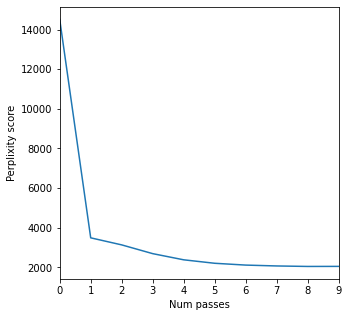

In [135]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(model_artm.score_tracker['PerplexityScore'].value)
ax.set_xticks(np.arange(0, num_collection_passes+1))
ax.set_xticklabels(np.arange(0, num_collection_passes+1))
ax.set_xlim([0, num_collection_passes - 1])
ax.set_xlabel('Num passes')
ax.set_ylabel('Perplixity score');

In [136]:
tokens_printer(model_artm)

topic1: врач, стоматолог, работа, среди, население, медицинский, учреждение, военнослужащий, профилактический, оказание

topic2: железа, отросток, имплантация, мягкий, слюнный, повреждение, губа, челюстный, характер, оперативный

topic3: летний, профилактика, профилактический, фторид, кальций, женщина, гигиенический, покрытие, кариозный, мероприятие

topic4: одонтогенный, флегмона, концентрация, челюстный, болевой, лазерный, гнойный, синдром, рана, боль

topic5: канал, обработка, корнев, рана, корневой, сплав, анаэробный, раствор, микрофлора, бактерия

topic6: сустав, височный, угол, отдел, передний, нижнечелюстной, сплав, смещение, дистальный, положение

topic7: составить, врач, стоматолог, обследовать, среднее, угол, высота, профилактический, часть, среди

topic8: пульпа, раствор, клетка, паста, пульпит, контрольный, эксперимент, реакция, дентин, оттиск

topic9: коронка, корень, цемент, прикус, размер, фиксация, свойство, твердый, напряжение, новый

topic10: фон, тяжелый, воспаление,

In [137]:
show_matrices_sparsity(model_artm)

Phi sparsity: 0.499
Theta sparsity: 0.026


### Regularizers: 0

[Decorrelator Phi](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html#decorrelator-phi)
* positive tau value differentiates tokens in a topic
* negative - makes tokens more common in different topics

In [138]:
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrPhi', tau=+1e5))

In [139]:
%%time
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

CPU times: user 2.8 s, sys: 28 ms, total: 2.83 s
Wall time: 1.21 s


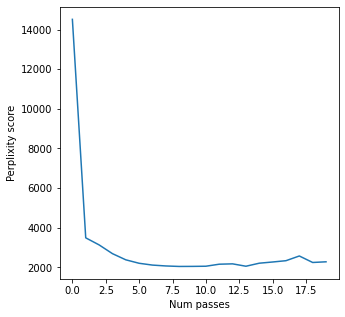

In [140]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(model_artm.score_tracker['PerplexityScore'].value)
ax.set_xlabel('Num passes')
ax.set_ylabel('Perplixity score');

In [141]:
tokens_printer(model_artm)

topic1: прикус, положение, зубочелюстной, мероприятие, рост, болезнь, возрастной, составить, основание, гигиена

topic2: повреждение, губа, мягкий, железа, врожденный, отросток, челюстный, расщелина, небо, внчс

topic4: концентрация, болевой, синдром, одонтогенный, лазерный, рана, боль, население, челюстный, клетка

topic5: рана, ран, канал, ранение, обработка, заживление, раневой, лазер, травма, лазерный

topic6: сплав, отдел, угол, сустав, височный, передний, размер, коронка, моляр, положение

topic7: врач, медицинский, стоматолог, канал, составить, профилактический, среднее, обследовать, оказание, низкий

topic8: раствор, паста, пульпит, пульпа, оттиск, состав, дентин, население, канал, клетка

topic9: постоянный, коронка, прикус, нагрузка, корень, свойство, твердый, моляр, размер, кариозный

topic10: фон, профилактика, низкий, профилактический, контрольный, тяжелый, гигиена, влияние, воспаление, так



In [142]:
show_matrices_sparsity(model_artm)

Phi sparsity: 0.723
Theta sparsity: 0.502


### Regularizers: 1
[SmoothSparsePhiRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#decorrelator-phi)
* positive tau value smoothes phi matrix
* negative - sparses phi matrix

In [143]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e3, dictionary=dictionary))
# tau = -1e5: слово будет домножаться на его частоту во всей коллекции

In [144]:
%%time
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

CPU times: user 2.75 s, sys: 39.2 ms, total: 2.79 s
Wall time: 1.27 s


In [145]:
tokens_printer(model_artm)

topic1: прикус, положение, стадия, зубочелюстной, рост, основание, язык, мероприятие, глоточный, болезнь

topic2: челюстный, повреждение, мягкий, губа, отросток, рана, гнойный, вмешательство, врожденный, железа

topic4: клетка, рана, концентрация, болевой, одонтогенный, синдром, фон, десна, медицинский, врач

topic6: отдел, размер, угол, передний, височный, положение, коронка, сустав, часть, моляр

topic7: составить, канал, врач, угол, высота, медицинский, часть, среднее, получить, стоматолог

topic8: раствор, паста, клетка, пульпит, оттиск, пульпа, дентин, состав, обладать, корнев

topic9: нагрузка, постоянный, коронка, корень, свойство, напряжение, твердый, кариозный, новый, прикус

topic10: профилактический, профилактика, низкий, среди, контрольный, мероприятие, гигиена, стоматолог, тяжелый, влияние



In [146]:
show_matrices_sparsity(model_artm)

Phi sparsity: 0.821
Theta sparsity: 0.592


### Regularizers: 2

[SmoothThetaRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#smooth-sparse-theta)

* positive tau value smoothes theta matrix
* negative - sparses theta matrix

In [147]:
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-10))

In [148]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

In [149]:
tokens_printer(model_artm)

topic2: мягкий, день, сопровождаться, небо, губа, челюстный, повреждение, реакция, гнойный, отросток

topic6: угол, врач, низкий, зубочелюстной, коронка, пульпа, моляр, работа, достоверно, пломба

topic7: канал, составить, врач, концентрация, среднее, обработка, отсутствие, медицинский, стоматолог, зависимость

topic9: прикус, постоянный, профилактический, положение, размер, первый, величина, свойство, профилактика, новый

topic10: составить, врач, достоверно, пульпа, население, профилактический, наблюдаться, часть, стоматолог, выше



In [150]:
show_matrices_sparsity(model_artm)

Phi sparsity: 0.887
Theta sparsity: 0.871


### Regularizers: 3
Change value of Phi Decorrelator

In [151]:
model_artm.regularizers['DecorrPhi'].tau = 1e8
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

In [152]:
tokens_printer(model_artm)

topic2: гнойный, флегмона, шея, остеосинтез, диск, отломок, раневой, кожа, иум, лимфатический

topic7: остеопороз, военнослужащий, отбеливание, пенсионер, язвенный, интерлейкина, гнатическа, задний, черта, вантовый

topic9: надежный, кто, пятно, пищеварение, верхушка, мнр, эпулис, синадента, завод, диета

topic10: вегетативный, рексода, хобл, ил, цитокин, лой, тяж, секстант, гемофилия, выживаемость



In [153]:
show_matrices_sparsity(model_artm)

Phi sparsity: 0.967
Theta sparsity: 0.964


### Regularizers: 4
[TopicSelectionThetaRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#topic-selection-theta)

[Reading](https://d3c33hcgiwev3.cloudfront.net/C8BvukDlEemFOA6Hm29iNA_858c5220dc5842f183b7bef43ed31181_4-1.Tematicheskoe_modelirovanie-_1_.pdf?Expires=1633132800&Signature=ZqSPAJBBy2-SYV8GQAqtLy2CMl7UZmlWALg02JSYbJr93H7XMbFFx8wXhCgkOuTZC4dzeH52oPMLTfy58C5673mnJQi5f3vV3BikOxXa1PLRatGbe-XEO7w7oIHbGRhjNbiw2PBLZ8vt-2FRn1dJu0zUq3~yL8SafQoH9cEpcUs_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) p.13 ???

In [154]:
model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionTheta', tau=1))
# model_artm.regularizers['TopicSelectionTheta'].tau = 1

In [155]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

In [156]:
tokens_printer(model_artm)

topic2: флегмона, гнойный, шея, диск, раневой, порок, регенерат, носоглотка, поток, просвет

topic9: кто, пятно, эпулис, мнр, синадента, завод, пищеварение, антенатальный, диета, прочностный



In [157]:
show_matrices_sparsity(model_artm)

Phi sparsity: 0.989
Theta sparsity: 0.992


In [158]:
# model_artm.score_tracker['top_words']